In [100]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
# Reading data.
bureau = pd.read_csv('./data/bureau.csv')
bureau_balance = pd.read_csv('./data/bureau_balance.csv')

In [18]:
# Lowering column names.
bureau.columns = [x.lower() for x in bureau.columns]
bureau_balance.columns = [x.lower() for x in bureau_balance.columns]

In [21]:
bureau.head()

,sk_id_curr,sk_id_bureau,credit_active,credit_currency,days_credit,credit_day_overdue,days_credit_enddate,days_enddate_fact,amt_credit_max_overdue,cnt_credit_prolong,amt_credit_sum,amt_credit_sum_debt,amt_credit_sum_limit,amt_credit_sum_overdue,credit_type,days_credit_update,amt_annuity
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [23]:
bureau_balance.head()

,sk_id_bureau,months_balance,status
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


A closed loan doesn't mean a 'good' loan because a DPD could be 5 (written off or sold to collection agency) and only after that, the loan was closed.

In [88]:
# Analyzing Bureau balance data.
bureau_balance_group = bureau_balance.groupby(['sk_id_bureau', 'status']).count()

In [90]:
bureau_balance_group = bureau_balance_group.rename(columns={'months_balance': 'count'}).reset_index()

In [91]:
bureau_balance_pivot = pd.pivot_table(bureau_balance_group, values='count', columns='status', index=['sk_id_bureau'], fill_value=0).reset_index()

In [92]:
# Cleaning.
bureau_balance_pivot = bureau_balance_pivot.drop(columns=['C'])
bureau_balance_pivot
for i in [0, 1, 2, 3, 4, 5]:
    bureau_balance_pivot = bureau_balance_pivot.rename(columns={str(i): 'dpd_{}'.format(i)})
bureau_balance_pivot.columns

Index(['sk_id_bureau', 'dpd_0', 'dpd_1', 'dpd_2', 'dpd_3', 'dpd_4', 'dpd_5',
       'X'],
      dtype='object', name='status')

In [93]:
conditions = [bureau_balance_pivot['dpd_5'] > 0, bureau_balance_pivot['dpd_4'] > 0, bureau_balance_pivot['dpd_3'] > 0, bureau_balance_pivot['dpd_2'] > 0, bureau_balance_pivot['dpd_1'] > 0, bureau_balance_pivot['dpd_0'] > 0]
results = [5, 4, 3, 2, 1, 0]
bureau_balance_pivot['max_dpd'] = np.select(conditions, results)

In [109]:
bureau_balance_pivot.head()

status,sk_id_bureau,dpd_0,dpd_1,dpd_2,dpd_3,dpd_4,dpd_5,X,max_dpd
0,5001709,0,0,0,0,0,0,11,0
1,5001710,5,0,0,0,0,0,30,0
2,5001711,3,0,0,0,0,0,1,0
3,5001712,10,0,0,0,0,0,0,0
4,5001713,0,0,0,0,0,0,22,0


[Text(0.5, 0, 'DPD Days'),
 Text(0, 0.5, 'Percentage  of defaulters'),
 Text(0.5, 1.0, '')]

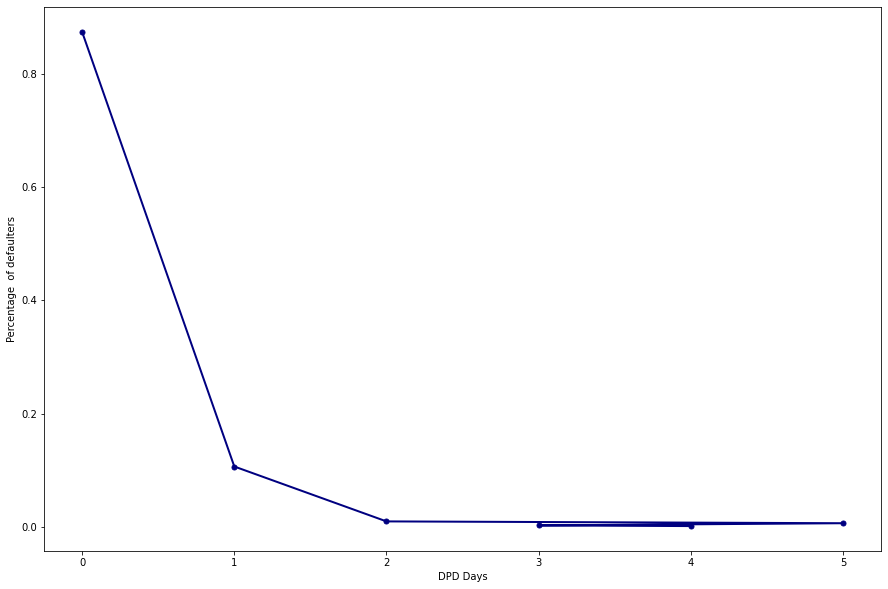

In [108]:
plt.figure(figsize=(15, 10))
dpd_plot = (bureau_balance_pivot['max_dpd'].value_counts()/bureau_balance_pivot['max_dpd'].value_counts().sum()).plot(lw=2,colormap='jet',marker='.',markersize=10)
dpd_plot.set(xlabel="DPD Days",ylabel="Percentage  of defaulters", title= "")


<AxesSubplot:xlabel='max_dpd', ylabel='percentage_of_loans'>

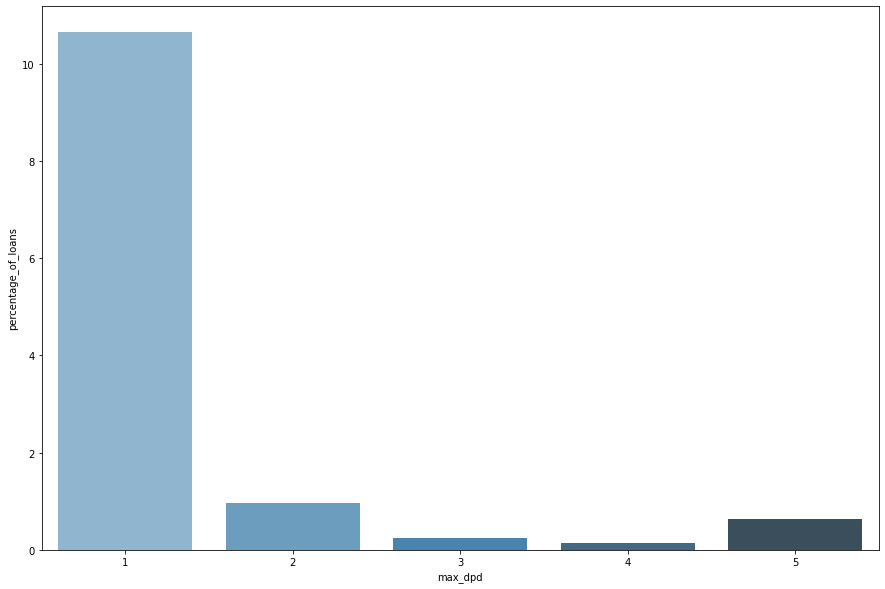

In [119]:
# Percentage of loans across max DPD.
plt.figure(figsize=(15, 10))
bureau_balance_dpd = (bureau_balance_pivot['max_dpd'].value_counts()*100/bureau_balance_pivot['max_dpd'].value_counts().sum()).reset_index()
bureau_balance_dpd = bureau_balance_dpd.rename(columns={'index': 'max_dpd', 'max_dpd': 'percentage_of_loans'})

sns.barplot(x='max_dpd', y='percentage_of_loans', data=bureau_balance_dpd.loc[bureau_balance_dpd['max_dpd'] != 0], palette="Blues_d")

#### Inference:
1. 11% of Credit Bureau loans have a maximum DPD of 1 ie. 30 days.
2. 0.6% of Credit Bureau loans have a maximum DPD of 5 ie. 150 days after which they get sold off or written off.
3. 0.25% of Credit Bureau loans have a maximum DPD of 3 ie. 90 days.
4. 0.13% of Credit Bureau loans have a maximum DPD of 4 ie. 120 days.
5. 1% of  Credit Bureau loans have a maximum DPD of 2 ie. 60 days.

Overall, maximum DPDs are a measure of severity of delay in payments (days).

In [131]:
bureau_balance_dpd

,max_dpd,percentage_of_loans
0,0,87.366695
1,1,10.650298
2,2,0.959267
3,5,0.637880
4,3,0.254100
5,4,0.131760


In [137]:
# Joining with bureau.
bureau_merged = pd.merge(bureau, bureau_balance_pivot, on=['sk_id_bureau'], how='left')

In [257]:
bureau_merged.head(10)

,sk_id_curr,sk_id_bureau,credit_active,credit_currency,days_credit,credit_day_overdue,days_credit_enddate,days_enddate_fact,amt_credit_max_overdue,cnt_credit_prolong,...,days_credit_update,amt_annuity,dpd_0,dpd_1,dpd_2,dpd_3,dpd_4,dpd_5,X,max_dpd
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,...,-131,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,...,-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,...,-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,...,-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,...,-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,215354,5714467,Active,currency 1,-273,0,27460.0,NaN,0.0,0,...,-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,215354,5714468,Active,currency 1,-43,0,79.0,NaN,0.0,0,...,-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,162297,5714469,Closed,currency 1,-1896,0,-1684.0,-1710.0,14985.0,0,...,-1710,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,162297,5714470,Closed,currency 1,-1146,0,-811.0,-840.0,0.0,0,...,-840,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,162297,5714471,Active,currency 1,-1146,0,-484.0,NaN,0.0,0,...,-690,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [235]:
bureau_merged['sk_id_curr'].nunique()

305811

For around, 1 million Credit Bureau credits, we do not have monthly credit bureau data.

In [195]:
bureau_merged['credit_active'].unique()

array(['Closed', 'Active', 'Sold', 'Bad debt'], dtype=object)

In [185]:
# Evaluating important client active loan features.
client_loans_active = bureau_merged.loc[bureau_merged['credit_active'] == 'Active'].groupby(['sk_id_curr'], as_index=False).agg(total_active_loans = pd.NamedAgg(column='sk_id_curr', aggfunc='count'),
                                                                                                                                 max_day_gap_before_applying_CB_active_credit = pd.NamedAgg(column='days_credit', aggfunc='min'),
                                                                                                                                 min_day_gap_before_applying_CB_active_credit = pd.NamedAgg(column='days_credit', aggfunc='max'),
                                                                                                                                 max_days_past_due_CB_active_credit = pd.NamedAgg(column='credit_day_overdue', aggfunc='max'),
                                                                                                                                 max_amt_overdue_CB_active_credit = pd.NamedAgg(column='amt_credit_max_overdue', aggfunc='max'),
                                                                                                                                 total_count_CB_active_credit_prolong = pd.NamedAgg(column='cnt_credit_prolong', aggfunc='sum'),
                                                                                                                                 max_count_CB_active_credit_prolong = pd.NamedAgg(column='cnt_credit_prolong', aggfunc='max'),
                                                                                                                                 total_current_credit_amt_CB_active_credit = pd.NamedAgg(column='amt_credit_sum', aggfunc='sum'),
                                                                                                                                 total_current_debt_amt_CB_active_credit = pd.NamedAgg(column='amt_credit_sum_debt', aggfunc='sum'),
                                                                                                                                 total_current_amt_overdue_CB_active_credit = pd.NamedAgg(column='amt_credit_sum_overdue', aggfunc='sum'),
                                                                                                                                 max_DPD_overall_CB_active_credit = pd.NamedAgg(column='max_dpd', aggfunc='max'),
                                                                                                                                 total_max_DPD_overall_CB_active_credit = pd.NamedAgg(column='max_dpd', aggfunc='sum'))

# The days are negative i.e. measured before application.
client_loans_active['max_day_gap_before_applying_CB_active_credit'] = client_loans_active['max_day_gap_before_applying_CB_active_credit'].multiply(-1)
client_loans_active['min_day_gap_before_applying_CB_active_credit'] = client_loans_active['min_day_gap_before_applying_CB_active_credit'].multiply(-1)
client_loans_active

,sk_id_curr,total_active_loans,max_day_gap_before_applying_CB_active_credit,min_day_gap_before_applying_CB_active_credit,max_days_past_due_CB_active_credit,max_amt_overdue_CB_active_credit,total_count_CB_active_credit_prolong,max_count_CB_active_credit_prolong,total_current_credit_amt_CB_active_credit,total_current_debt_amt_CB_active_credit,total_current_amt_overdue_CB_active_credit,max_DPD_overall_CB_active_credit,total_max_DPD_overall_CB_active_credit
0,100001,3,559,49,0,NaN,0,0,884025.000,596686.500,0.0,1.0,1.0
1,100002,2,1042,103,0,40.500,0,0,481988.565,245781.000,0.0,1.0,1.0
2,100003,1,606,606,0,0.000,0,0,810000.000,0.000,0.0,NaN,0.0
3,100005,2,137,62,0,0.000,0,0,598626.000,568408.500,0.0,0.0,0.0
4,100008,1,78,78,0,0.000,0,0,267606.000,240057.000,0.0,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
251810,456247,3,712,309,0,22027.500,0,0,4113000.000,2193390.000,0.0,0.0,0.0
251811,456249,2,2612,483,0,0.000,0,0,405000.000,163071.000,0.0,NaN,0.0
251812,456250,2,824,760,0,0.000,0,0,2603110.050,2232040.095,0.0,0.0,0.0
251813,456253,2,919,713,0,NaN,0,0,2610000.000,1795833.000,0.0,0.0,0.0


In [237]:
# Getting other data.
client_loans_closed = bureau_merged.loc[bureau_merged['credit_active'] == 'Closed'].groupby(['sk_id_curr'], as_index=False).size()
client_loans_sold = bureau_merged.loc[bureau_merged['credit_active'] == 'Sold'].groupby(['sk_id_curr'], as_index=False).size()
client_loans_bad_debt = bureau_merged.loc[bureau_merged['credit_active'] == 'Bad debt'].groupby(['sk_id_curr'], as_index=False).size()
client_loans_closed = client_loans_closed.rename(columns={'size': 'total_closed_loans'})
client_loans_bad_debt = client_loans_bad_debt.rename(columns={'size': 'total_bad_debt'})
client_loans_sold = client_loans_sold.rename(columns={'size': 'total_sold_loans'})

In [238]:
client_loans_summary = pd.merge(client_loans_closed, client_loans_sold, on=['sk_id_curr'], how='outer')
client_loans_summary = pd.merge(client_loans_summary, client_loans_bad_debt, on=['sk_id_curr'], how='outer')
client_loans_summary = pd.merge(client_loans_summary, client_loans_active, on=['sk_id_curr'], how='outer')
client_loans_summary['total_closed_loans'] = client_loans_summary['total_closed_loans'].fillna(0)
client_loans_summary['total_sold_loans'] = client_loans_summary['total_sold_loans'].fillna(0)
client_loans_summary['total_bad_debt'] = client_loans_summary['total_bad_debt'].fillna(0)
client_loans_summary['total_active_loans'] = client_loans_summary['total_active_loans'].fillna(0)
client_loans_summary['total_loans'] = client_loans_summary['total_active_loans'] + client_loans_summary['total_bad_debt'] + client_loans_summary['total_sold_loans'] + client_loans_summary['total_closed_loans']
client_loans_summary = client_loans_summary[['sk_id_curr', 'total_loans', 'total_closed_loans', 'total_sold_loans',
       'total_bad_debt', 'total_active_loans',
       'max_day_gap_before_applying_CB_active_credit',
       'min_day_gap_before_applying_CB_active_credit',
       'max_days_past_due_CB_active_credit',
       'max_amt_overdue_CB_active_credit',
       'total_count_CB_active_credit_prolong',
       'max_count_CB_active_credit_prolong',
       'total_current_credit_amt_CB_active_credit',
       'total_current_debt_amt_CB_active_credit',
       'total_current_amt_overdue_CB_active_credit',
       'max_DPD_overall_CB_active_credit',
       'total_max_DPD_overall_CB_active_credit']]
client_loans_summary

,sk_id_curr,total_loans,total_closed_loans,total_sold_loans,total_bad_debt,total_active_loans,max_day_gap_before_applying_CB_active_credit,min_day_gap_before_applying_CB_active_credit,max_days_past_due_CB_active_credit,max_amt_overdue_CB_active_credit,total_count_CB_active_credit_prolong,max_count_CB_active_credit_prolong,total_current_credit_amt_CB_active_credit,total_current_debt_amt_CB_active_credit,total_current_amt_overdue_CB_active_credit,max_DPD_overall_CB_active_credit,total_max_DPD_overall_CB_active_credit
0,100001,7.0,4.0,0.0,0.0,3.0,559.0,49.0,0.0,NaN,0.0,0.0,884025.000,596686.500,0.0,1.0,1.0
1,100002,8.0,6.0,0.0,0.0,2.0,1042.0,103.0,0.0,40.5,0.0,0.0,481988.565,245781.000,0.0,1.0,1.0
2,100003,4.0,3.0,0.0,0.0,1.0,606.0,606.0,0.0,0.0,0.0,0.0,810000.000,0.000,0.0,NaN,0.0
3,100004,2.0,2.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100005,3.0,1.0,0.0,0.0,2.0,137.0,62.0,0.0,0.0,0.0,0.0,598626.000,568408.500,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305806,456226,2.0,0.0,0.0,0.0,2.0,748.0,162.0,0.0,NaN,0.0,0.0,450000.000,51012.000,0.0,0.0,0.0
305807,456229,1.0,0.0,0.0,0.0,1.0,1839.0,1839.0,0.0,11353.5,1.0,1.0,258750.000,0.000,0.0,NaN,0.0
305808,456232,2.0,0.0,0.0,0.0,2.0,764.0,295.0,0.0,NaN,0.0,0.0,801000.000,517342.500,0.0,NaN,0.0
305809,456233,1.0,0.0,0.0,0.0,1.0,203.0,203.0,0.0,0.0,0.0,0.0,282663.315,223943.895,0.0,0.0,0.0


In [239]:
client_loans_summary.describe()

,sk_id_curr,total_loans,total_closed_loans,total_sold_loans,total_bad_debt,total_active_loans,max_day_gap_before_applying_CB_active_credit,min_day_gap_before_applying_CB_active_credit,max_days_past_due_CB_active_credit,max_amt_overdue_CB_active_credit,total_count_CB_active_credit_prolong,max_count_CB_active_credit_prolong,total_current_credit_amt_CB_active_credit,total_current_debt_amt_CB_active_credit,total_current_amt_overdue_CB_active_credit,max_DPD_overall_CB_active_credit,total_max_DPD_overall_CB_active_credit
count,305811.000000,305811.000000,305811.000000,305811.000000,305811.000000,305811.000000,251815.000000,251815.000000,251815.000000,1.330000e+05,251815.000000,251815.000000,2.518150e+05,2.518150e+05,2.518150e+05,111149.000000,251815.000000
mean,278047.300091,5.612709,3.529216,0.021343,0.000069,2.062081,940.044835,419.578754,4.374493,3.838487e+03,0.027580,0.027087,1.334376e+06,7.814595e+05,2.247292e+02,0.291429,0.176248
std,102849.568343,4.430354,3.430504,0.158325,0.008286,1.791724,715.432550,466.847043,83.634675,1.943360e+04,0.206072,0.200948,2.358591e+06,1.757110e+06,1.572542e+04,0.645597,0.687888
min,100001.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,-6.978830e+06,0.000000e+00,0.000000,0.000000
25%,188878.500000,2.000000,1.000000,0.000000,0.000000,1.000000,372.000000,130.000000,0.000000,0.000000e+00,0.000000,0.000000,2.378651e+05,5.845500e+04,0.000000e+00,0.000000,0.000000
50%,277895.000000,4.000000,3.000000,0.000000,0.000000,2.000000,770.000000,264.000000,0.000000,0.000000e+00,0.000000,0.000000,6.606045e+05,2.849632e+05,0.000000e+00,0.000000,0.000000
75%,367184.500000,8.000000,5.000000,0.000000,0.000000,3.000000,1317.000000,520.000000,0.000000,1.935225e+02,0.000000,0.000000,1.554508e+06,8.386515e+05,0.000000e+00,0.000000,0.000000
max,456255.000000,116.000000,108.000000,9.000000,1.000000,32.000000,2922.000000,2922.000000,2770.000000,4.351414e+06,9.000000,9.000000,3.347397e+08,3.344983e+08,3.756681e+06,5.000000,35.000000


Mean active loans:  2.0620808277007696
Mean total loans:  5.612708502964249
Mean closed loans:  3.5292157574449576
Mean bad debt:  6.86698647203665e-05
Mean sold loans:  0.02134324795380153


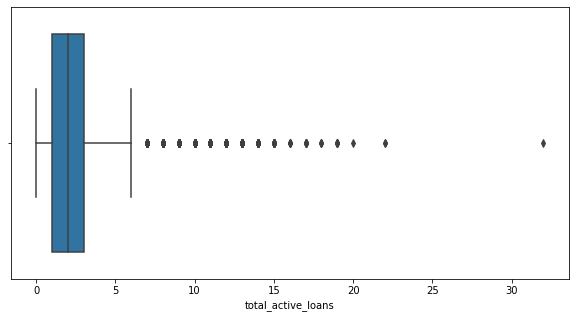

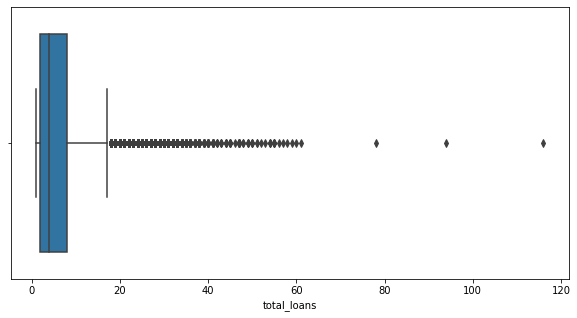

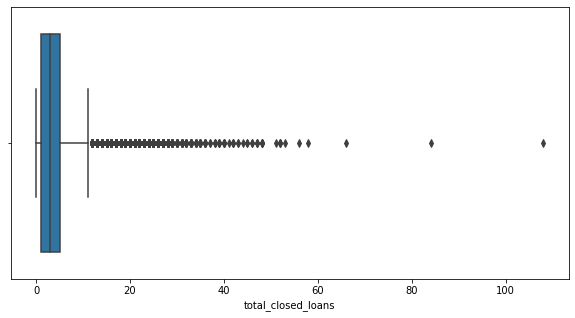

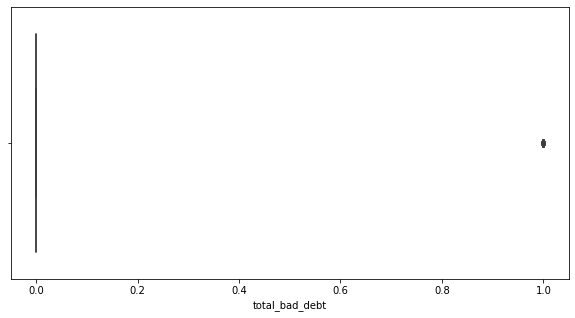

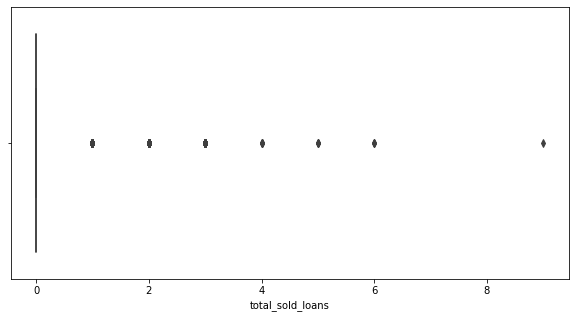

In [240]:
# Visualizing active Credit Bureau loans.
plt.figure(figsize=(10, 5))
sns.boxplot(x=client_loans_summary['total_active_loans'])
plt.figure(figsize=(10, 5))
sns.boxplot(x=client_loans_summary['total_loans'])
plt.figure(figsize=(10, 5))
sns.boxplot(x=client_loans_summary['total_closed_loans'])
plt.figure(figsize=(10, 5))
sns.boxplot(x=client_loans_summary['total_bad_debt'])
plt.figure(figsize=(10, 5))
sns.boxplot(x=client_loans_summary['total_sold_loans'])
print("Mean active loans: ", client_loans_summary['total_active_loans'].mean())
print("Mean total loans: ", client_loans_summary['total_loans'].mean())
print("Mean closed loans: ", client_loans_summary['total_closed_loans'].mean())
print("Mean bad debt: ", client_loans_summary['total_bad_debt'].mean())
print("Mean sold loans: ", client_loans_summary['total_sold_loans'].mean())

#### Inference:
Clients applying for HomeCredit loan have 2 active loans on an average. <br>
Clients applying for HomeCredit loan have 5.6 total loans on an average. <br>
Clients applying for HomeCredit loan have 3.5 closed loans on an average. <br>

                                     credit_type  percentage
0                                Consumer credit   72.919750
1                                    Credit card   23.432093
2                                       Car loan    1.613234
3                                       Mortgage    1.071469
4                                      Microloan    0.723188
5                  Loan for business development    0.115065
6                           Another type of loan    0.059251
7                           Unknown type of loan    0.032335
8         Loan for working capital replenishment    0.027324
9                      Cash loan (non-earmarked)    0.003263
10                              Real estate loan    0.001573
11            Loan for the purchase of equipment    0.001107
12  Loan for purchase of shares (margin lending)    0.000233
13                          Mobile operator loan    0.000058
14                              Interbank credit    0.000058


<AxesSubplot:xlabel='credit_type', ylabel='percentage'>

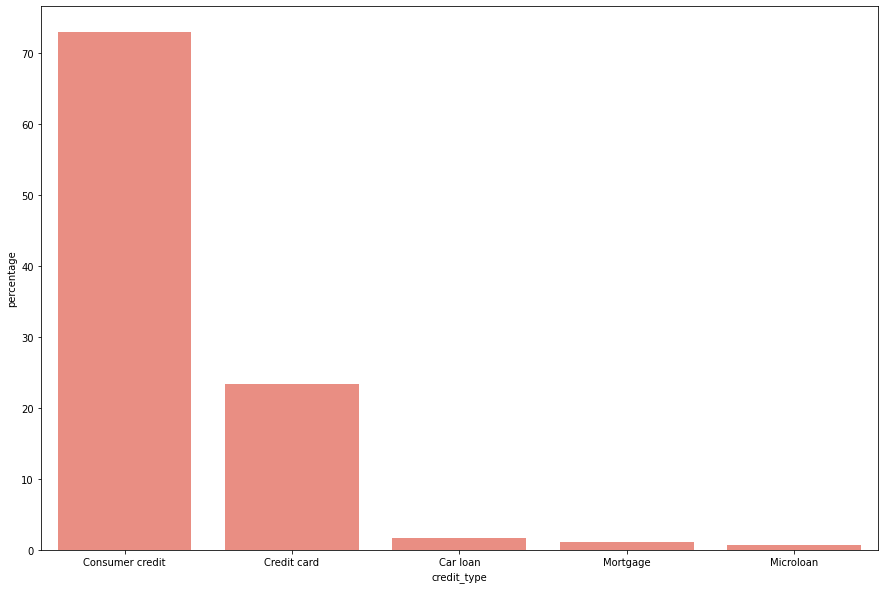

In [253]:
# Active loans.
active_loans_type = (bureau_merged['credit_type'].value_counts()*100/bureau_merged['credit_type'].value_counts().sum()).reset_index()
active_loans_type = active_loans_type.rename(columns={'index': 'credit_type', 'credit_type': 'percentage'})
print(active_loans_type)
plt.figure(figsize=(15, 10))
sns.barplot(x='credit_type', y='percentage', data=active_loans_type.loc[0:4,], color="salmon")

Consumer credit (revolving loans) and credit card comprise 96% of applications made on CB before getting to Home Credit.

In [263]:
client_loans_type_active = bureau_merged.loc[bureau_merged['credit_active'] == 'Active'].groupby(['sk_id_curr', 'credit_type'], as_index=False).agg(total_active_loans = pd.NamedAgg(column='sk_id_curr', aggfunc='count'),
                                                                                                                                 max_day_gap_before_applying_CB_active_credit = pd.NamedAgg(column='days_credit', aggfunc='min'),
                                                                                                                                 min_day_gap_before_applying_CB_active_credit = pd.NamedAgg(column='days_credit', aggfunc='max'),
                                                                                                                                 max_days_past_due_CB_active_credit = pd.NamedAgg(column='credit_day_overdue', aggfunc='max'),
                                                                                                                                 max_amt_overdue_CB_active_credit = pd.NamedAgg(column='amt_credit_max_overdue', aggfunc='max'),
                                                                                                                                 total_count_CB_active_credit_prolong = pd.NamedAgg(column='cnt_credit_prolong', aggfunc='sum'),
                                                                                                                                 max_count_CB_active_credit_prolong = pd.NamedAgg(column='cnt_credit_prolong', aggfunc='max'),
                                                                                                                                 total_current_credit_amt_CB_active_credit = pd.NamedAgg(column='amt_credit_sum', aggfunc='sum'),
                                                                                                                                 total_current_debt_amt_CB_active_credit = pd.NamedAgg(column='amt_credit_sum_debt', aggfunc='sum'),
                                                                                                                                 total_current_amt_overdue_CB_active_credit = pd.NamedAgg(column='amt_credit_sum_overdue', aggfunc='sum'),
                                                                                                                                 max_DPD_overall_CB_active_credit = pd.NamedAgg(column='max_dpd', aggfunc='max'),
                                                                                                                                 total_max_DPD_overall_CB_active_credit = pd.NamedAgg(column='max_dpd', aggfunc='sum'))

# The days are negative i.e. measured before application.
client_loans_type_active['max_day_gap_before_applying_CB_active_credit'] = client_loans_active['max_day_gap_before_applying_CB_active_credit'].multiply(-1)
client_loans_type_active['min_day_gap_before_applying_CB_active_credit'] = client_loans_active['min_day_gap_before_applying_CB_active_credit'].multiply(-1)

client_loans_type_active

,sk_id_curr,credit_type,total_active_loans,max_day_gap_before_applying_CB_active_credit,min_day_gap_before_applying_CB_active_credit,max_days_past_due_CB_active_credit,max_amt_overdue_CB_active_credit,total_count_CB_active_credit_prolong,max_count_CB_active_credit_prolong,total_current_credit_amt_CB_active_credit,total_current_debt_amt_CB_active_credit,total_current_amt_overdue_CB_active_credit,max_DPD_overall_CB_active_credit,total_max_DPD_overall_CB_active_credit
0,100001,Consumer credit,3,-559.0,-49.0,0,NaN,0,0,884025.000,596686.500,0.0,1.0,1.0
1,100002,Consumer credit,1,-1042.0,-103.0,0,NaN,0,0,450000.000,245781.000,0.0,1.0,1.0
2,100002,Credit card,1,-606.0,-606.0,0,40.500,0,0,31988.565,0.000,0.0,0.0,0.0
3,100003,Credit card,1,-137.0,-62.0,0,0.000,0,0,810000.000,0.000,0.0,NaN,0.0
4,100005,Consumer credit,2,-78.0,-78.0,0,0.000,0,0,598626.000,568408.500,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
385900,456250,Credit card,1,NaN,NaN,0,0.000,0,0,450000.000,391731.615,0.0,0.0,0.0
385901,456253,Consumer credit,1,NaN,NaN,0,NaN,0,0,2250000.000,1624797.000,0.0,0.0,0.0
385902,456253,Credit card,1,NaN,NaN,0,NaN,0,0,360000.000,171036.000,0.0,0.0,0.0
385903,456255,Consumer credit,4,NaN,NaN,0,15439.905,0,0,2249532.000,1473852.510,0.0,0.0,0.0


(0.0, 50000000.0)

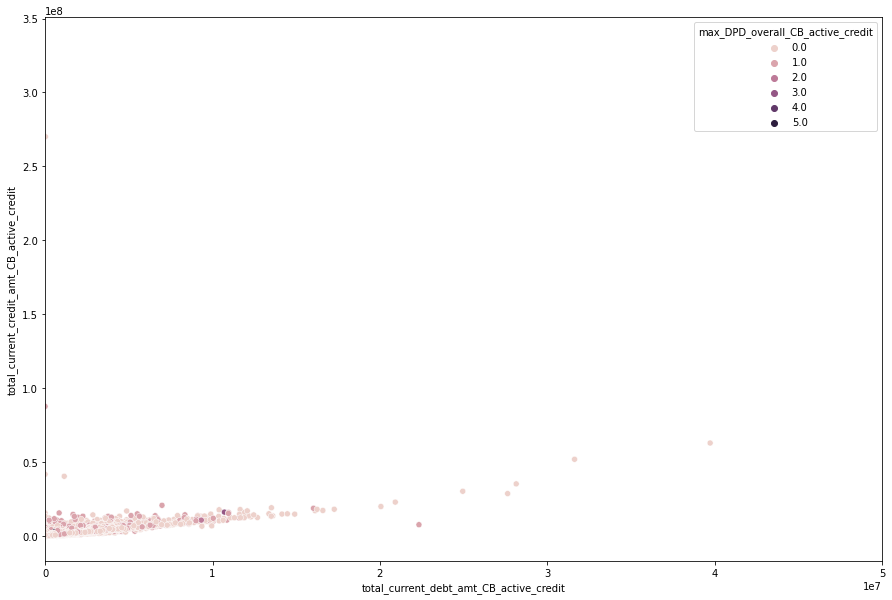

In [265]:
plt.figure(figsize=(15, 10))
sns.scatterplot(data=client_loans_type_active.loc[client_loans_type_active['credit_type'] == 'Consumer credit'], x="total_current_debt_amt_CB_active_credit", y="total_current_credit_amt_CB_active_credit", hue='max_DPD_overall_CB_active_credit')
plt.xlim(0, 50000000)

In [267]:
x = client_loans_type_active.loc[~client_loans_type_active['max_DPD_overall_CB_active_credit'].isnull()]
x

,sk_id_curr,credit_type,total_active_loans,max_day_gap_before_applying_CB_active_credit,min_day_gap_before_applying_CB_active_credit,max_days_past_due_CB_active_credit,max_amt_overdue_CB_active_credit,total_count_CB_active_credit_prolong,max_count_CB_active_credit_prolong,total_current_credit_amt_CB_active_credit,total_current_debt_amt_CB_active_credit,total_current_amt_overdue_CB_active_credit,max_DPD_overall_CB_active_credit,total_max_DPD_overall_CB_active_credit
0,100001,Consumer credit,3,-559.0,-49.0,0,NaN,0,0,884025.000,596686.500,0.0,1.0,1.0
1,100002,Consumer credit,1,-1042.0,-103.0,0,NaN,0,0,450000.000,245781.000,0.0,1.0,1.0
2,100002,Credit card,1,-606.0,-606.0,0,40.500,0,0,31988.565,0.000,0.0,0.0,0.0
4,100005,Consumer credit,2,-78.0,-78.0,0,0.000,0,0,598626.000,568408.500,0.0,0.0,0.0
8,100010,Consumer credit,1,-262.0,-128.0,0,NaN,0,0,675000.000,348007.500,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
385900,456250,Credit card,1,NaN,NaN,0,0.000,0,0,450000.000,391731.615,0.0,0.0,0.0
385901,456253,Consumer credit,1,NaN,NaN,0,NaN,0,0,2250000.000,1624797.000,0.0,0.0,0.0
385902,456253,Credit card,1,NaN,NaN,0,NaN,0,0,360000.000,171036.000,0.0,0.0,0.0
385903,456255,Consumer credit,4,NaN,NaN,0,15439.905,0,0,2249532.000,1473852.510,0.0,0.0,0.0


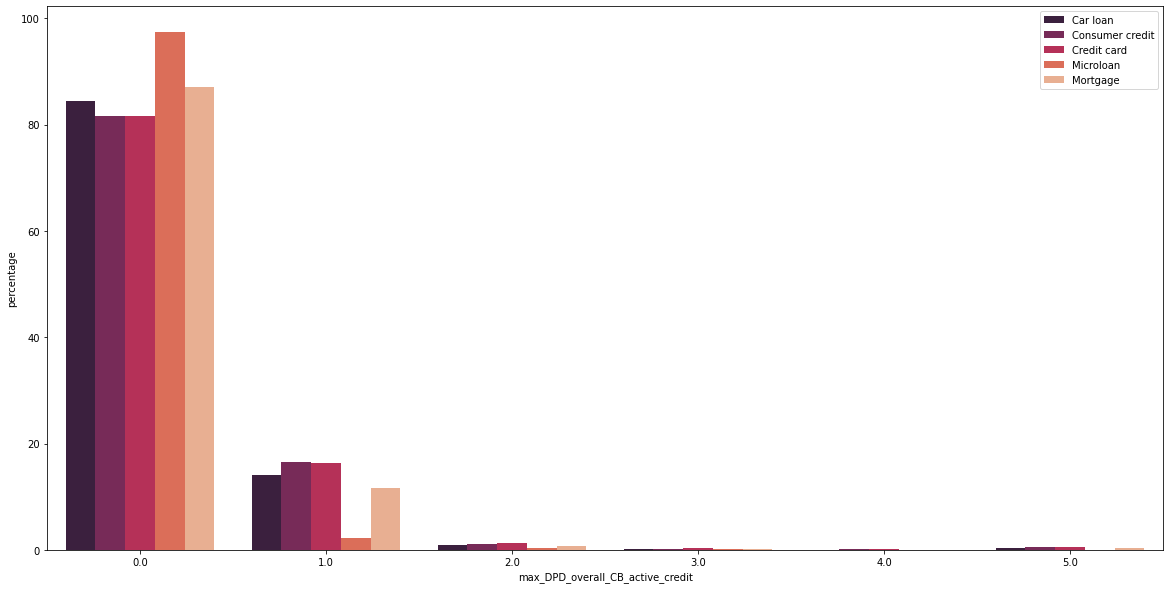

In [317]:
loan_type_summary = client_loans_type_active.groupby(['credit_type', 'max_DPD_overall_CB_active_credit']).size().reset_index()
loan_type_summary = loan_type_summary.rename(columns={0: 'num'})
x = loan_type_summary.groupby(['credit_type'])['num'].sum().reset_index()
x = x.rename(columns={'num': 'total'})
z = pd.merge(loan_type_summary, x, on=['credit_type'], how='left')
z['percentage'] = z['num']*100/z['total']

plt.figure(figsize=(20, 10))
sns.barplot(x='max_DPD_overall_CB_active_credit', y='percentage', data=z.loc[z['credit_type'].isin(['Car loan', 'Mortgage', 'Microloan', 'Consumer credit', 'Credit card'])], hue="credit_type", palette='rocket')
plt.legend(loc='upper right')

   index  max_DPD_overall_CB_active_credit
0    0.0                         81.613932
1    1.0                         16.527514
2    2.0                          1.028416
3    5.0                          0.475388
4    3.0                          0.229333
5    4.0                          0.125417


<AxesSubplot:xlabel='max_DPD_overall_CB_active_credit', ylabel='percentage_of_loans'>

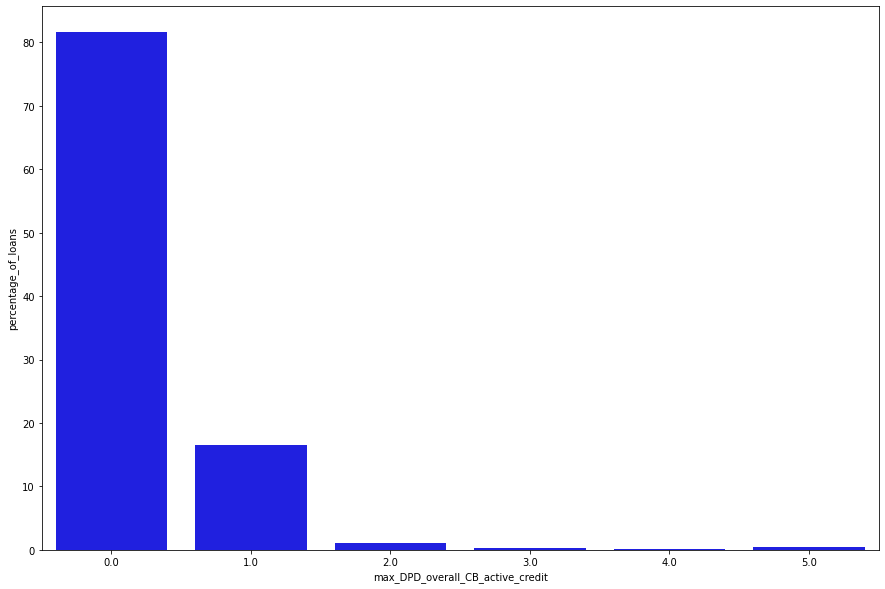

In [283]:
dpd_consumer_credit = (x.loc[x['credit_type'] == 'Consumer credit']['max_DPD_overall_CB_active_credit'].value_counts()*100/x.loc[x['credit_type'] == 'Consumer credit']['max_DPD_overall_CB_active_credit'].value_counts().sum()).reset_index()
print(dpd_consumer_credit)
dpd_consumer_credit = dpd_consumer_credit.rename(columns={'index': 'max_DPD_overall_CB_active_credit', 'max_DPD_overall_CB_active_credit': 'percentage_of_loans'})
plt.figure(figsize=(15, 10))
sns.barplot(x='max_DPD_overall_CB_active_credit', y='percentage_of_loans', data=dpd_consumer_credit, color="blue")

   index  max_DPD_overall_CB_active_credit
0    0.0                         81.527582
1    1.0                         16.326021
2    2.0                          1.221067
3    5.0                          0.527070
4    3.0                          0.273393
5    4.0                          0.124867


<AxesSubplot:xlabel='max_DPD_overall_CB_active_credit', ylabel='percentage_of_loans'>

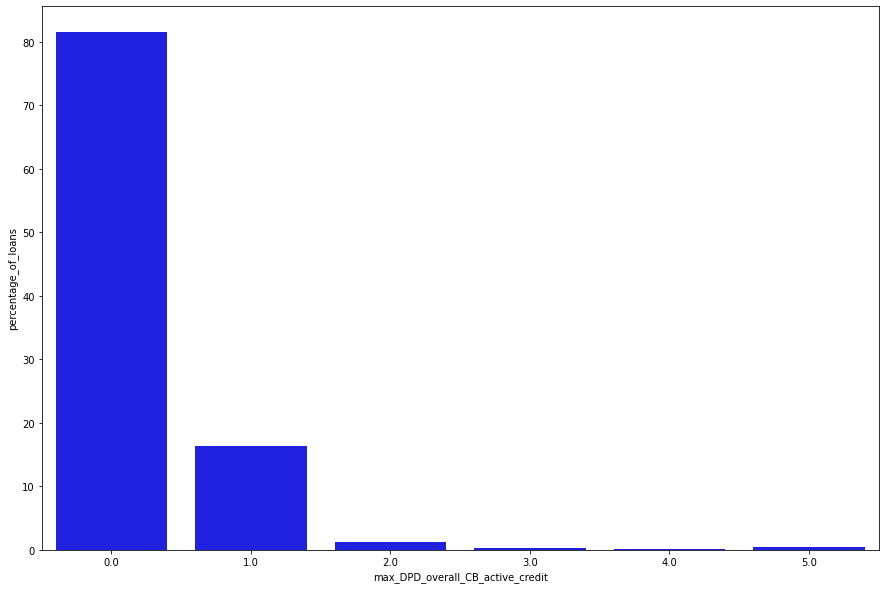

In [285]:
dpd_credit_card = (x.loc[x['credit_type'] == 'Credit card']['max_DPD_overall_CB_active_credit'].value_counts()*100/x.loc[x['credit_type'] == 'Credit card']['max_DPD_overall_CB_active_credit'].value_counts().sum()).reset_index()
print(dpd_credit_card)
dpd_credit_card = dpd_credit_card.rename(columns={'index': 'max_DPD_overall_CB_active_credit', 'max_DPD_overall_CB_active_credit': 'percentage_of_loans'})
plt.figure(figsize=(15, 10))
sns.barplot(x='max_DPD_overall_CB_active_credit', y='percentage_of_loans', data=dpd_credit_card, color="blue")